In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
from datetime import datetime, date, timedelta

import yfinance as yfin
from var import VaR
import scipy.stats

import matplotlib.pyplot as plt
import seaborn as sns
#from yahoofinancials import YahooFinancials

#pd.set_option('display.float_format', '{:.10f}'.format)

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')

# Assignment
Create a Github account if you do not already have one and download a VAR library.
Using the library that you have chosen and historical data (available from Yahoo Finance and other sources) calculate the VaR for your  investment portfolio.
Document your work in a presentation and post it to the Discussion Forum and comment on and discuss the document and posted work of others.

# Variables

In [2]:
start_date = datetime(2020, 1, 1)
end_date = datetime.now()
alpha = 0.05

yfin.pdr_override()

#start_date = "2022-01-01"
#end_date = "2023-08-31"
#alpha = 0.01

# Functions

# Load Data

folio_df = pd.read_csv('https://raw.githubusercontent.com/dsimband/DATA618/main/w5/data/DATA618_Portfolio.csv', 
                 dtype={
                    'ID': 'int',
                    'Price': 'float',
                    'Shares': 'float',
                    'Value': 'float', 
                 })


folio_df = folio_df[folio_df['Shares'] > 0]
folio_df = folio_df.groupby(['Ticker']).sum()
folio_df['Morningstar_Category'].fillna('Other', inplace=True)
folio_df.reset_index(inplace=True)
folio_df.drop(columns='ID', inplace=True)
folio_df

In [3]:
folio_df = pd.read_csv('./data/DATA618_Portfolio.csv', 
                 dtype={
                    'ID': 'int',
                    'Price': 'float',
                    'Shares': 'float',
                    'Value': 'float', 
                 })


folio_df = folio_df[folio_df['Shares'] > 0]
folio_df = folio_df.groupby(['Ticker','BondName','Class'])[['Shares','Value']].sum()
folio_df.reset_index(inplace=True)
#folio_df['Morningstar_Category'].fillna('Other', inplace=True)
folio_df

,Ticker,BondName,Class,Shares,Value
0,ALTVX,AB Municipal Income National Advisor,Interest Rate Sensitive Exposures,"106,383.0000","1,000.0000"
1,BLUEX,AMG Veritas Global Real Return I,Economically Sensitive Exposures,"14,201.0000",500.0000
2,BPLSX,Boston Partners Long/Short Equity Instl,Economically Sensitive Exposures,"49,967.0000",750.0000
3,C_A_S_H,Cash,Cash,"4,469,000.0000","4,469.0000"
4,DFAR,Dimensional US Real Estate ETF,Economically Sensitive Exposures,"108,468.0000","2,250.0000"
...,...,...,...,...,...
30,VIGI,Vanguard Intl Div Apprec ETF,Economically Sensitive Exposures,"40,481.0000","3,000.0000"
31,VNQ,Vanguard Real Estate ETF,Economically Sensitive Exposures,"40,221.0000","3,250.0000"
32,VO,Vanguard Mid-Cap ETF,Economically Sensitive Exposures,"9,234.0000","2,000.0000"
33,VONG,Vanguard Russell 1000 Growth ETF,Economically Sensitive Exposures,"41,501.0000","3,000.0000"


In [4]:
folio_df.groupby(['Class'])[['Value']].sum()

,Value
Class,
Cash,"4,469.0000"
Economically Sensitive Exposures,"50,250.0000"
Interest Rate Sensitive Exposures,"29,000.0000"


In [5]:
portfolio_total = folio_df['Value'].sum()
folio_df['port_percent'] = folio_df['Value'] / portfolio_total
#weights = (folio_df['port_percent'].values)

folio_df['Test'] = (folio_df['port_percent'] * 83975) - folio_df['Value']
folio_df['Test'].sum()

## Calculate Percentage

In [6]:
ticker_lst = list(folio_df['Ticker'])
weights = (folio_df['port_percent'].values)

In [7]:
#ticker_lst

In [8]:
price_df = pdr.get_data_yahoo(ticker_lst, start=start_date, end=end_date)
price_df = price_df[['Adj Close']]
price_df.columns = price_df.columns.get_level_values(1)
price_df['C_A_S_H'] = 1

percent_df = price_df.pct_change()
percent_df = percent_df[1:]
percent_df.fillna(0, inplace=True)
percent_df.index = pd.to_datetime(percent_df.index)

price_df

[*********************100%%**********************]  35 of 35 completed


1 Failed download:
['C_A_S_H']: Exception('%ticker%: No timezone found, symbol may be delisted')


,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,...,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
Date,,,,,,,,,,,,,,,
2020-01-02,9.6599,26.7265,10.5664,1,NaN,24.2896,25.5027,...,19.0211,22.4164,64.4088,79.9387,168.9928,44.4435,49.6847
2020-01-03,9.6875,26.6375,10.5296,1,NaN,24.4752,25.4781,...,19.0925,22.5165,63.6910,80.4356,168.2368,44.1430,49.8609
2020-01-06,9.6875,26.7877,10.4745,1,NaN,24.5018,25.4676,...,19.0657,22.4892,63.8328,80.5315,168.4731,44.4047,49.8794
2020-01-07,9.6967,26.7932,10.4501,1,NaN,24.2101,25.4163,...,19.0390,22.4528,63.6821,79.6336,168.4258,44.3247,49.9443
2020-01-08,9.6967,26.8823,10.4562,1,NaN,24.2985,25.5768,...,19.0122,22.4164,64.1518,79.8777,168.7282,44.6495,49.9443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25,9.2300,34.2600,15.0000,1,19.7800,23.0400,32.2600,...,18.2200,20.6100,72.2400,76.6245,209.5800,68.9900,48.3700
2023-09-26,9.2200,33.8200,14.8800,1,19.4100,22.6100,31.8900,...,18.2000,20.5800,71.4600,75.2281,206.6000,67.8600,48.3300
2023-09-27,9.2000,33.8100,14.8600,1,19.2600,22.4400,32.1000,...,18.1400,20.4800,71.3000,74.7230,207.2900,67.9600,48.2400


In [9]:
percent_df.loc[['2023-09-11']]

,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,...,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
Date,,,,,,,,,,,,,,,
2023-09-11,0.0000,0.0063,0.0054,0.0000,-0.0014,-0.0008,0.0024,...,-0.0005,-0.0010,0.0075,0.0001,0.0020,0.0109,0.0004


In [10]:

price_df.query("index == '2023-09-11 00:00:00'")

,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,...,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
Date,,,,,,,,,,,,,,,
2023-09-11 00:00:00,9.4000,35.2100,15.0100,1,20.7436,24.2468,33.1387,...,18.3700,20.8500,74.1083,80.8038,216.5903,72.2877,49.1800


### Test Prices

In [11]:
p_df = price_df.query("index == '2023-09-11 00:00:00'")
p_df = p_df.T
p_df.reset_index(inplace=True)
p_df.columns = ['Ticker','Price']
#p_df.columns = ['Ticker']
p_df

,Ticker,Price
0,ALTVX,9.4000
1,BLUEX,35.2100
2,BPLSX,15.0100
3,C_A_S_H,1.0000
4,DFAR,20.7436
...,...,...
30,VIGI,74.1083
31,VNQ,80.8038
32,VO,216.5903
33,VONG,72.2877


In [12]:
t_df = folio_df.copy()
t_df = t_df.merge(p_df, how='left', left_on='Ticker', right_on='Ticker' )
t_df['calc_value'] =  t_df['Shares'] * t_df['Price'] 
t_df['check'] = t_df['calc_value'] - (t_df['Value'] * 1000)
t_df

,Ticker,BondName,Class,Shares,Value,port_percent,Price,calc_value,check
0,ALTVX,AB Municipal Income National Advisor,Interest Rate Sensitive Exposures,"106,383.0000","1,000.0000",0.0119,9.4000,"1,000,000.1594",0.1594
1,BLUEX,AMG Veritas Global Real Return I,Economically Sensitive Exposures,"14,201.0000",500.0000,0.0060,35.2100,"500,017.1970",17.1970
2,BPLSX,Boston Partners Long/Short Equity Instl,Economically Sensitive Exposures,"49,967.0000",750.0000,0.0090,15.0100,"750,004.6814",4.6814
3,C_A_S_H,Cash,Cash,"4,469,000.0000","4,469.0000",0.0534,1.0000,"4,469,000.0000",0.0000
4,DFAR,Dimensional US Real Estate ETF,Economically Sensitive Exposures,"108,468.0000","2,250.0000",0.0269,20.7436,"2,250,015.2414",15.2414
...,...,...,...,...,...,...,...,...,...
30,VIGI,Vanguard Intl Div Apprec ETF,Economically Sensitive Exposures,"40,481.0000","3,000.0000",0.0358,74.1083,"2,999,977.7533",-22.2467
31,VNQ,Vanguard Real Estate ETF,Economically Sensitive Exposures,"40,221.0000","3,250.0000",0.0388,80.8038,"3,250,010.9674",10.9674
32,VO,Vanguard Mid-Cap ETF,Economically Sensitive Exposures,"9,234.0000","2,000.0000",0.0239,216.5903,"1,999,995.2669",-4.7331
33,VONG,Vanguard Russell 1000 Growth ETF,Economically Sensitive Exposures,"41,501.0000","3,000.0000",0.0358,72.2877,"3,000,012.0231",12.0231


In [13]:
t_df.sort_values(by='check', ascending=True)

,Ticker,BondName,Class,Shares,Value,port_percent,Price,calc_value,check
23,SCHD,Schwab US Dividend Equity ETF™,Economically Sensitive Exposures,"41,027.0000","3,000.0000",0.0358,73.1219,"2,999,971.3534",-28.6466
11,IGRO,iShares International Dividend Gr ETF,Economically Sensitive Exposures,"32,610.0000","2,000.0000",0.0239,61.3300,"1,999,971.4841",-28.5159
34,VTEB,Vanguard Tax-Exempt Bond ETF,Interest Rate Sensitive Exposures,"20,333.0000","1,000.0000",0.0119,49.1800,"999,976.9462",-23.0538
30,VIGI,Vanguard Intl Div Apprec ETF,Economically Sensitive Exposures,"40,481.0000","3,000.0000",0.0358,74.1083,"2,999,977.7533",-22.2467
16,JPRE,JPMorgan Realty Income ETF,Economically Sensitive Exposures,"60,695.0000","2,500.0000",0.0299,41.1893,"2,499,987.3745",-12.6255
...,...,...,...,...,...,...,...,...,...
12,IMCB,iShares Morningstar Mid-Cap ETF,Economically Sensitive Exposures,"64,494.0000","4,000.0000",0.0478,62.0215,"4,000,014.5974",14.5974
4,DFAR,Dimensional US Real Estate ETF,Economically Sensitive Exposures,"108,468.0000","2,250.0000",0.0269,20.7436,"2,250,015.2414",15.2414
29,VICSX,Vanguard Interm-Term Corp Bd Idx Admiral,Interest Rate Sensitive Exposures,"95,924.0000","2,000.0000",0.0239,20.8500,"2,000,015.4366",15.4366
1,BLUEX,AMG Veritas Global Real Return I,Economically Sensitive Exposures,"14,201.0000",500.0000,0.0060,35.2100,"500,017.1970",17.1970


In [14]:
t_df['calc_value'].sum()

83719064.45972347

In [15]:
t_df['check'].sum()

64.45972347259521

In [16]:
price_df.query("index == '2023-09-11 00:00:00'")['VNQ']

Date
2023-09-11 00:00:00   80.8038
Name: VNQ, dtype: float64

In [17]:
p_df[p_df['Ticker'] == 'JPEM']

,Ticker,Price
15,JPEM,50.9158


In [18]:
price_df['C_A_S_H']

Date
2020-01-02    1
2020-01-03    1
2020-01-06    1
2020-01-07    1
2020-01-08    1
             ..
2023-09-25    1
2023-09-26    1
2023-09-27    1
2023-09-28    1
2023-09-29    1
Name: C_A_S_H, Length: 943, dtype: int64

In [19]:
shares_df = folio_df[['Ticker','Shares']]
#folio_df = folio_df.groupby(['Ticker'])[['Shares']].sum()
#folio_df.reset_index(inplace=True)
shares_df.set_index('Ticker', drop=True, inplace=True)
shares_df[['Shares']].round(0)

,Shares
Ticker,
ALTVX,"106,383.0000"
BLUEX,"14,201.0000"
BPLSX,"49,967.0000"
C_A_S_H,"4,469,000.0000"
DFAR,"108,468.0000"
...,...
VIGI,"40,481.0000"
VNQ,"40,221.0000"
VO,"9,234.0000"


In [20]:
#t1 = list(shares_df.index)
#t2 = list(price_df.columns)
price_df

,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,...,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
Date,,,,,,,,,,,,,,,
2020-01-02,9.6599,26.7265,10.5664,1,NaN,24.2896,25.5027,...,19.0211,22.4164,64.4088,79.9387,168.9928,44.4435,49.6847
2020-01-03,9.6875,26.6375,10.5296,1,NaN,24.4752,25.4781,...,19.0925,22.5165,63.6910,80.4356,168.2368,44.1430,49.8609
2020-01-06,9.6875,26.7877,10.4745,1,NaN,24.5018,25.4676,...,19.0657,22.4892,63.8328,80.5315,168.4731,44.4047,49.8794
2020-01-07,9.6967,26.7932,10.4501,1,NaN,24.2101,25.4163,...,19.0390,22.4528,63.6821,79.6336,168.4258,44.3247,49.9443
2020-01-08,9.6967,26.8823,10.4562,1,NaN,24.2985,25.5768,...,19.0122,22.4164,64.1518,79.8777,168.7282,44.6495,49.9443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25,9.2300,34.2600,15.0000,1,19.7800,23.0400,32.2600,...,18.2200,20.6100,72.2400,76.6245,209.5800,68.9900,48.3700
2023-09-26,9.2200,33.8200,14.8800,1,19.4100,22.6100,31.8900,...,18.2000,20.5800,71.4600,75.2281,206.6000,67.8600,48.3300
2023-09-27,9.2000,33.8100,14.8600,1,19.2600,22.4400,32.1000,...,18.1400,20.4800,71.3000,74.7230,207.2900,67.9600,48.2400


In [21]:
m_df = price_df.copy()
#m_df['Date'] = m_df.index
m_df.reset_index(inplace=True)
m_df = m_df.melt(id_vars=['Date'])
m_df

,Date,variable,value
0,2020-01-02,ALTVX,9.6599
1,2020-01-03,ALTVX,9.6875
2,2020-01-06,ALTVX,9.6875
3,2020-01-07,ALTVX,9.6967
4,2020-01-08,ALTVX,9.6967
...,...,...,...
33000,2023-09-25,VTEB,48.3700
33001,2023-09-26,VTEB,48.3300
33002,2023-09-27,VTEB,48.2400
33003,2023-09-28,VTEB,48.0300


In [22]:
l_df = folio_df[['Ticker','Class']] #.drop_duplicates() 
l_df

,Ticker,Class
0,ALTVX,Interest Rate Sensitive Exposures
1,BLUEX,Economically Sensitive Exposures
2,BPLSX,Economically Sensitive Exposures
3,C_A_S_H,Cash
4,DFAR,Economically Sensitive Exposures
...,...,...
30,VIGI,Economically Sensitive Exposures
31,VNQ,Economically Sensitive Exposures
32,VO,Economically Sensitive Exposures
33,VONG,Economically Sensitive Exposures


In [23]:
m_df = m_df.merge(l_df, how='left', left_on='variable', right_on='Ticker').merge(shares_df,how='left' ,left_on='Ticker', right_on='Ticker')
m_df['share_value'] = m_df['value'] * m_df['Shares']
m_df

,Date,variable,value,Ticker,Class,Shares,share_value
0,2020-01-02,ALTVX,9.6599,ALTVX,Interest Rate Sensitive Exposures,"106,383.0000","1,027,644.7485"
1,2020-01-03,ALTVX,9.6875,ALTVX,Interest Rate Sensitive Exposures,"106,383.0000","1,030,584.1965"
2,2020-01-06,ALTVX,9.6875,ALTVX,Interest Rate Sensitive Exposures,"106,383.0000","1,030,584.1965"
3,2020-01-07,ALTVX,9.6967,ALTVX,Interest Rate Sensitive Exposures,"106,383.0000","1,031,563.4376"
4,2020-01-08,ALTVX,9.6967,ALTVX,Interest Rate Sensitive Exposures,"106,383.0000","1,031,563.4376"
...,...,...,...,...,...,...,...
33000,2023-09-25,VTEB,48.3700,VTEB,Interest Rate Sensitive Exposures,"20,333.0000","983,507.1883"
33001,2023-09-26,VTEB,48.3300,VTEB,Interest Rate Sensitive Exposures,"20,333.0000","982,693.9272"
33002,2023-09-27,VTEB,48.2400,VTEB,Interest Rate Sensitive Exposures,"20,333.0000","980,863.9541"
33003,2023-09-28,VTEB,48.0300,VTEB,Interest Rate Sensitive Exposures,"20,333.0000","976,593.9652"


In [24]:
t_df = m_df.groupby(['Date','Class'])[['share_value']].sum().reset_index()
t_df

,Date,Class,share_value
0,2020-01-02,Cash,"4,469,000.0000"
1,2020-01-02,Economically Sensitive Exposures,"38,298,748.4339"
2,2020-01-02,Interest Rate Sensitive Exposures,"30,120,933.5914"
3,2020-01-03,Cash,"4,469,000.0000"
4,2020-01-03,Economically Sensitive Exposures,"38,125,692.5238"
...,...,...,...
2824,2023-09-28,Economically Sensitive Exposures,"48,229,242.3354"
2825,2023-09-28,Interest Rate Sensitive Exposures,"28,546,307.5982"
2826,2023-09-29,Cash,"4,469,000.0000"
2827,2023-09-29,Economically Sensitive Exposures,"48,193,309.1122"


In [25]:
t_df[t_df['Date'] == '2023-09-29']

,Date,Class,share_value
2826,2023-09-29,Cash,"4,469,000.0000"
2827,2023-09-29,Economically Sensitive Exposures,"48,193,309.1122"
2828,2023-09-29,Interest Rate Sensitive Exposures,"28,468,744.5006"


In [26]:
m_df

,Date,variable,value,Ticker,Class,Shares,share_value
0,2020-01-02,ALTVX,9.6599,ALTVX,Interest Rate Sensitive Exposures,"106,383.0000","1,027,644.7485"
1,2020-01-03,ALTVX,9.6875,ALTVX,Interest Rate Sensitive Exposures,"106,383.0000","1,030,584.1965"
2,2020-01-06,ALTVX,9.6875,ALTVX,Interest Rate Sensitive Exposures,"106,383.0000","1,030,584.1965"
3,2020-01-07,ALTVX,9.6967,ALTVX,Interest Rate Sensitive Exposures,"106,383.0000","1,031,563.4376"
4,2020-01-08,ALTVX,9.6967,ALTVX,Interest Rate Sensitive Exposures,"106,383.0000","1,031,563.4376"
...,...,...,...,...,...,...,...
33000,2023-09-25,VTEB,48.3700,VTEB,Interest Rate Sensitive Exposures,"20,333.0000","983,507.1883"
33001,2023-09-26,VTEB,48.3300,VTEB,Interest Rate Sensitive Exposures,"20,333.0000","982,693.9272"
33002,2023-09-27,VTEB,48.2400,VTEB,Interest Rate Sensitive Exposures,"20,333.0000","980,863.9541"
33003,2023-09-28,VTEB,48.0300,VTEB,Interest Rate Sensitive Exposures,"20,333.0000","976,593.9652"


ValueError: Could not interpret value `value` for parameter `y`

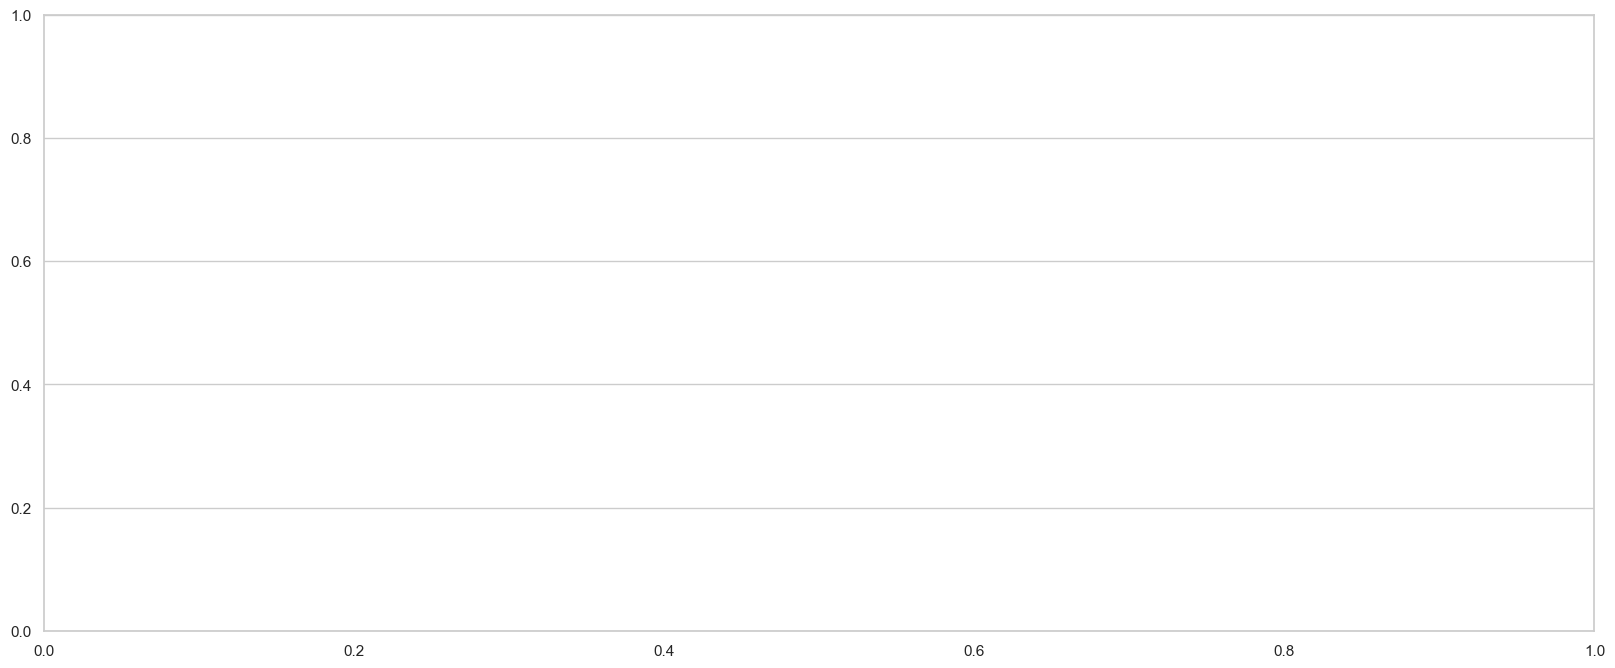

In [27]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()
plt.ticklabel_format(style='plain', axis='y')

# Plot
#ax.plot(m_df['Date'], m_df['value'], ,'gray')
sns.lineplot(data=t_df, x="Date", y="value", hue='Class')
#m_df.plot(kind='bar', stacked=True)

ax.set(title='Fed Effective Funds Rate Prediction');

In [ ]:
p_df = price_df.T

In [ ]:
l_df = folio_df[['Ticker','Class']] #.drop_duplicates() 
l_df

m_df = pval_df
m_df['Date'] = price_df.index
m_df = m_df.melt(id_vars=['Date'])

m_df = pd.merge(left=m_df, right=l_df, left_on='variable', right_on='Ticker')
m_df = m_df.groupby(['Date','Class'])[['value']].sum().reset_index()
#m_df = m_df.groupby(['Class'])[['value']].sum().reset_index()
m_df.sort_values('Date', inplace=True)
#m_df['value'] = round(m_df['value'],2)
m_df['value'] = m_df['value'].astype(int)
m_df.groupby('Class')['value'].sum()

In [ ]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()
plt.ticklabel_format(style='plain', axis='y')

# Plot
#ax.plot(m_df['Date'], m_df['value'], ,'gray')
sns.lineplot(data=m_df, x="Date", y="value", hue='Class')
#m_df.plot(kind='bar', stacked=True)

ax.set(title='Fed Effective Funds Rate Prediction');

percent_df = percent_df.pct_change()
percent_df = percent_df[1:]
percent_df.fillna(0, inplace=True)
percent_df.index = pd.to_datetime(percent_df.index)
percent_df['CASH'] = 0
percent_df

# Calculate VaR

In [ ]:
l2 = list(folio_df['Ticker'])
l1 = percent_df.columns
list_dif = set(l2).symmetric_difference(set(l1))


print('l1: ', len(l1), 'l2: ', len(l2), 'dif: ', list_dif)

In [ ]:
var = VaR(percent_df, weights, alpha=[0.05,0.025,0.01])
#var = VaR(percent_df, weights, alpha=0.05)
var

In [ ]:
var.info

In [ ]:
var.historic()

In [ ]:
print('VaR(95.0):', var.historic()['VaR(95.0)'][0]*100)
print('Portfolio VaR(95.0)', var.historic()['VaR(95.0)'][0]*portfolio_total*1000)

In [ ]:
var.parametric()

In [ ]:
print('VaR(95.0):', var.parametric()['VaR(95.0)'][0]*100)
print('Portfolio VaR(95.0)', var.parametric()['VaR(95.0)'][0]*portfolio_total*1000)

In [ ]:
var.monte_carlo()

In [ ]:
print('VaR(95.0):', var.monte_carlo()['VaR(95.0)'][0]*100)
print('Portfolio VaR(95.0)', var.monte_carlo()['VaR(95.0)'][0]*portfolio_total*1000)

In [ ]:
var.monte_carlo(stressed=True)

# Backtest

In [ ]:
bth = var.backtest(method='h')

In [ ]:
var.evaluate(bth)

In [ ]:
var.var_plot(bth)

In [ ]:
var.cvar_plot(bth)

In [ ]:
var.cdar_plot(bth)